In [1]:
%cd /raid6/home/yokoyama/cfm_for_activity_recognition
import sys

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import numpy as np

sys.path.append(".")
from src.data import NTU_RGBD
from src.utils import yaml_handler

/raid6/home/yokoyama/cfm_for_activity_recognition


In [2]:
# load config
config_path = "configs/model.yaml"
config = yaml_handler.load(config_path)

In [3]:
dataset = NTU_RGBD(
    "../datasets/ntu_rgbd/",
    config,
    False,
    split_type="cross_subject",
)
dataloader = DataLoader(
    dataset,
    1,
    shuffle=False,
    pin_memory=False,
)

creating: 100%|█████████████████████████████████████████████████| 276/276 [00:00<00:00, 1534.63it/s]


In [4]:
x = []
labels = []
for batch in tqdm(iter(dataloader), total=len(dataset)):
    x.append(batch[0].cpu().numpy())
    labels.append(batch[2].cpu().numpy().item())
x = np.concatenate(x)
labels = np.array(labels)
x.shape

100%|██████████| 287/287 [00:00<00:00, 7392.59it/s]


(287, 300, 25, 3)

In [5]:
unique_labels = np.unique(labels)

def plot_hist_one(x, label, th_abs=None):
    x_tmp = x[labels == label]
    x_tmp = x_tmp.reshape(-1, 3)
    x_tmp = x_tmp[np.all(~np.isnan(x_tmp), axis=1)]
    if th_abs is not None:
        mask = np.all(np.abs(x_tmp) > th_abs, axis=1)
        x_tmp = x_tmp[mask]
    plt.hist(x_tmp[:, 0], bins=200, alpha=0.5, label="x")
    plt.hist(x_tmp[:, 1], bins=200, alpha=0.5, label="y")
    plt.hist(x_tmp[:, 2], bins=200, alpha=0.5, label="d")
    plt.legend()
    plt.show()

def plot_hist(x, th_abs=None):
    ncol = 5
    nrow = np.ceil(len(unique_labels) // ncol)
    fig = plt.figure(figsize=(20, nrow * 4))
    axs = fig.subplots(nrow, ncol)
    for i, label in enumerate(unique_labels):
        j = i % ncol
        i = i // ncol
        x_tmp = x[labels == label]
        x_tmp = x_tmp.reshape(-1, 3)
        x_tmp = x_tmp[np.all(~np.isnan(x_tmp), axis=1)]
        if th_abs is not None:
            mask = np.all(np.abs(x_tmp) > th_abs, axis=1)
            x_tmp = x_tmp[mask]
        axs[i, j].hist(x_tmp[:, 0], bins=200, alpha=0.5, label="x")
        axs[i, j].hist(x_tmp[:, 1], bins=200, alpha=0.5, label="y")
        axs[i, j].hist(x_tmp[:, 2], bins=200, alpha=0.5, label="d")
    plt.legend()
    plt.show()

-0.058006335 0.43924996
-0.08599967 0.49375883
3.3036723 0.52324957


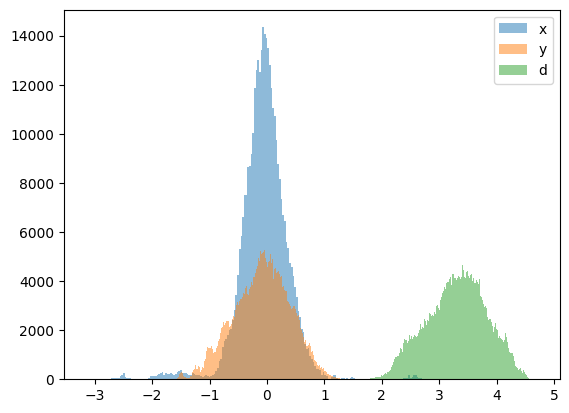

In [6]:
for i in range(3):
    x_tmp = x.reshape(-1, 3)
    print(np.nanmean(x_tmp[:, i]), np.nanstd(x_tmp[:, i]))
plot_hist_one(x, 27)

0.000109988236 0.012096583
8.430573e-05 0.03406109
-0.0010840321 0.017110804


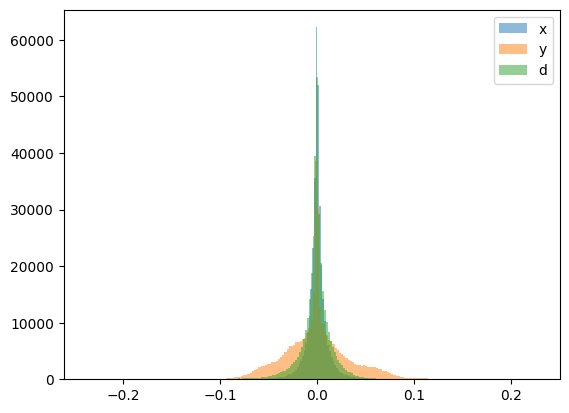

In [7]:
v = np.diff(x, axis=1)
for i in range(3):
    v_tmp = v.reshape(-1, 3)
    print(np.nanmean(v_tmp[:, i]), np.nanstd(v_tmp[:, i]))
plot_hist_one(v, 27)

-1.51557415e-05 0.007177721
-3.0743777e-05 0.011977172
8.053884e-05 0.008953044


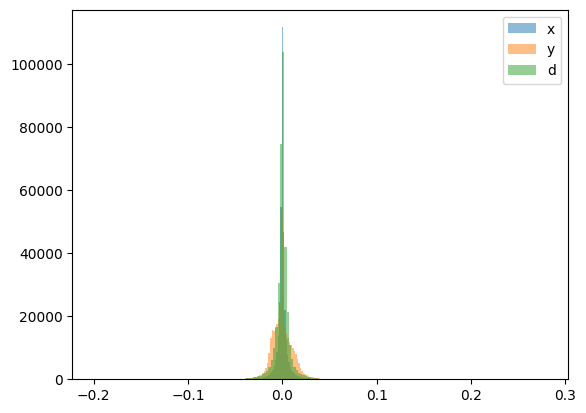

In [8]:
a = np.diff(v, axis=1)
for i in range(3):
    a_tmp = a.reshape(-1, 3)
    print(np.nanmean(a_tmp[:, i]), np.nanstd(a_tmp[:, i]))
plot_hist_one(a, 27)

-0.05798933 0.43410844
-0.1270072 0.495165
3.3638566 0.5353577


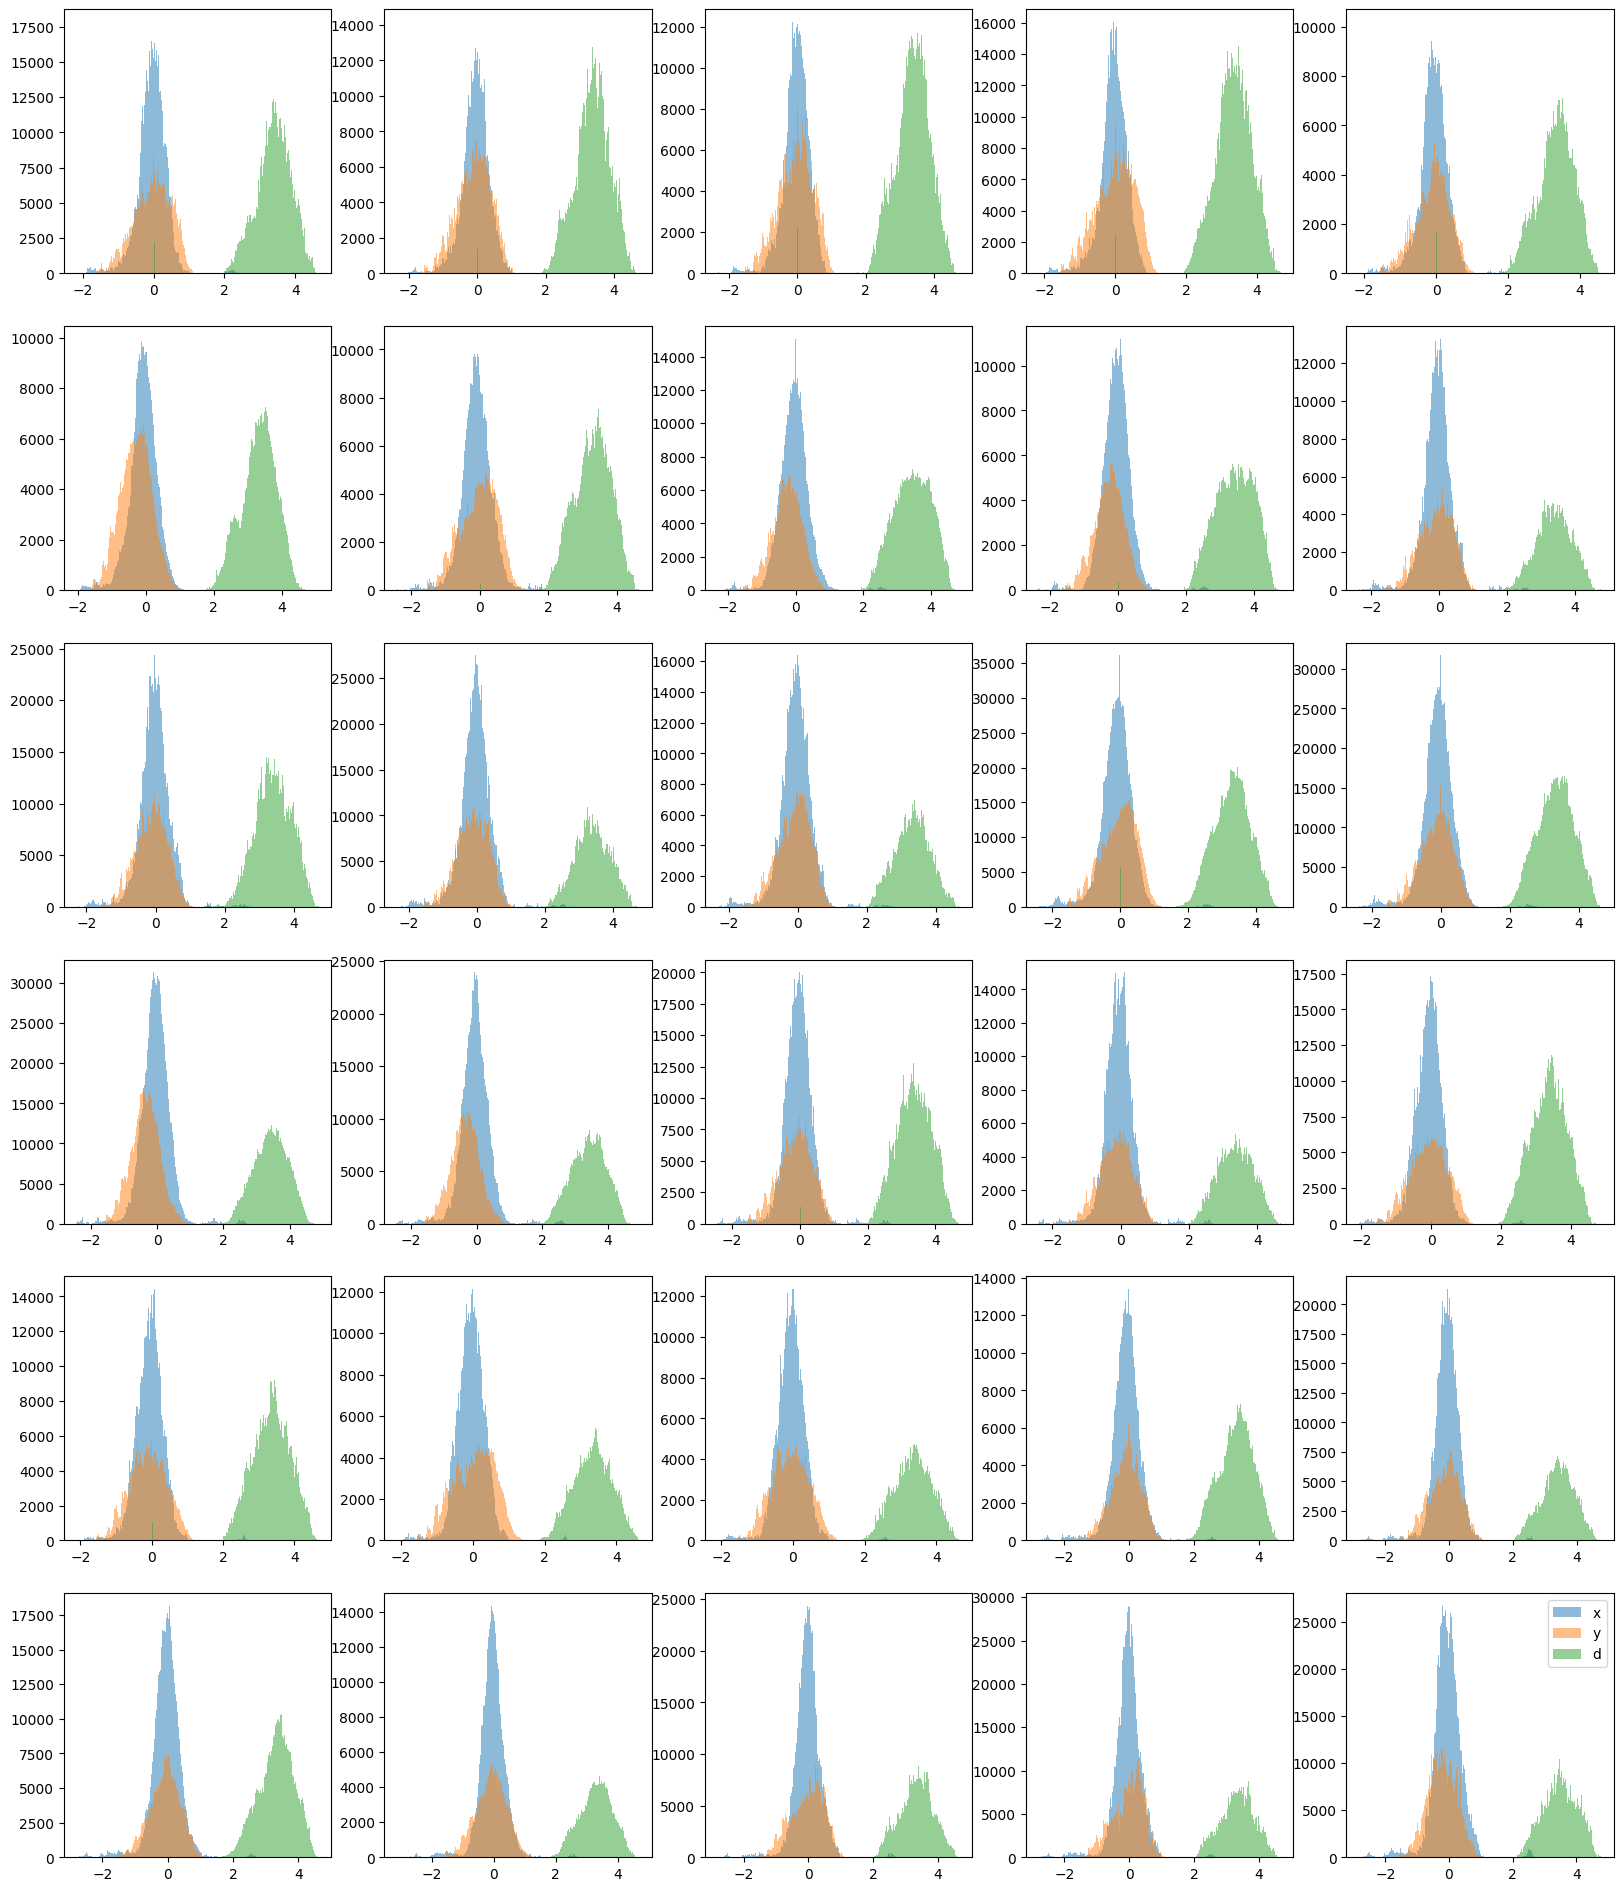

In [6]:
for i in range(3):
    x_tmp = x.reshape(-1, 3)
    print(np.nanmean(x_tmp[:, i]), np.nanstd(x_tmp[:, i]))
plot_hist(x)

In [7]:
x.shape

(8476, 300, 25, 3)

-3.5013858e-05 0.0105986195
0.0004625024 0.0141973905
-0.0003320189 0.015745915


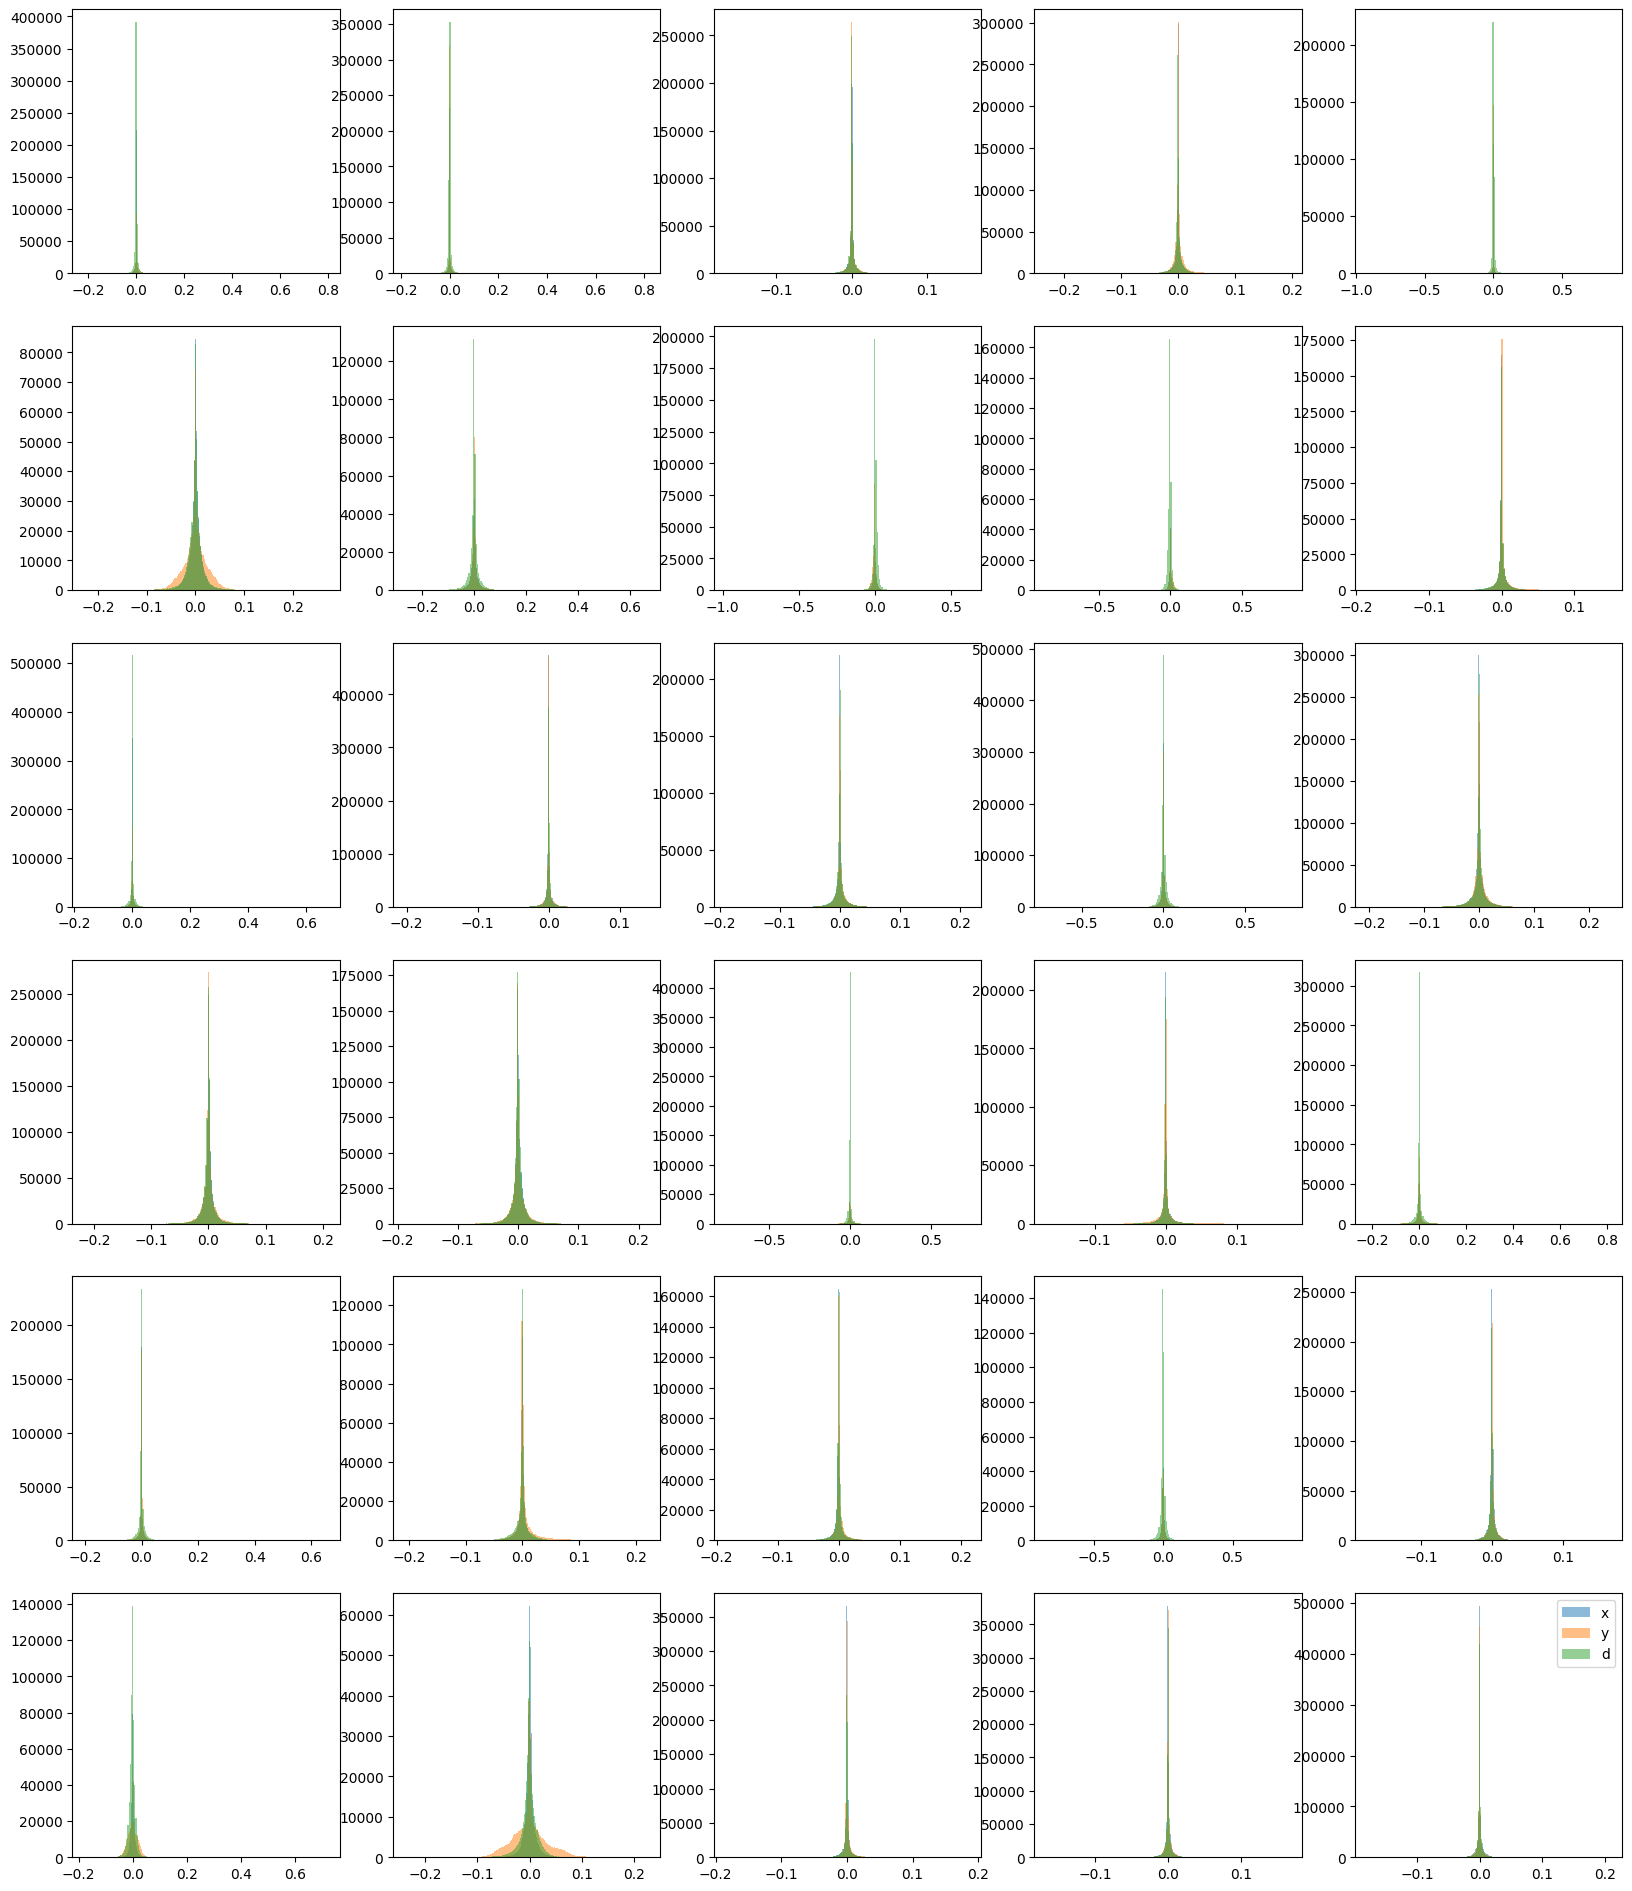

In [10]:
stride = 1
v = x[:, stride:] - x[:, :-stride]
for i in range(3):
    v_tmp = v.reshape(-1, 3)
    print(np.nanmean(v_tmp[:, i]), np.nanstd(v_tmp[:, i]))
plot_hist(v)

-0.000945221 0.096373
0.0075166104 0.14312667
-0.0069434326 0.14112748


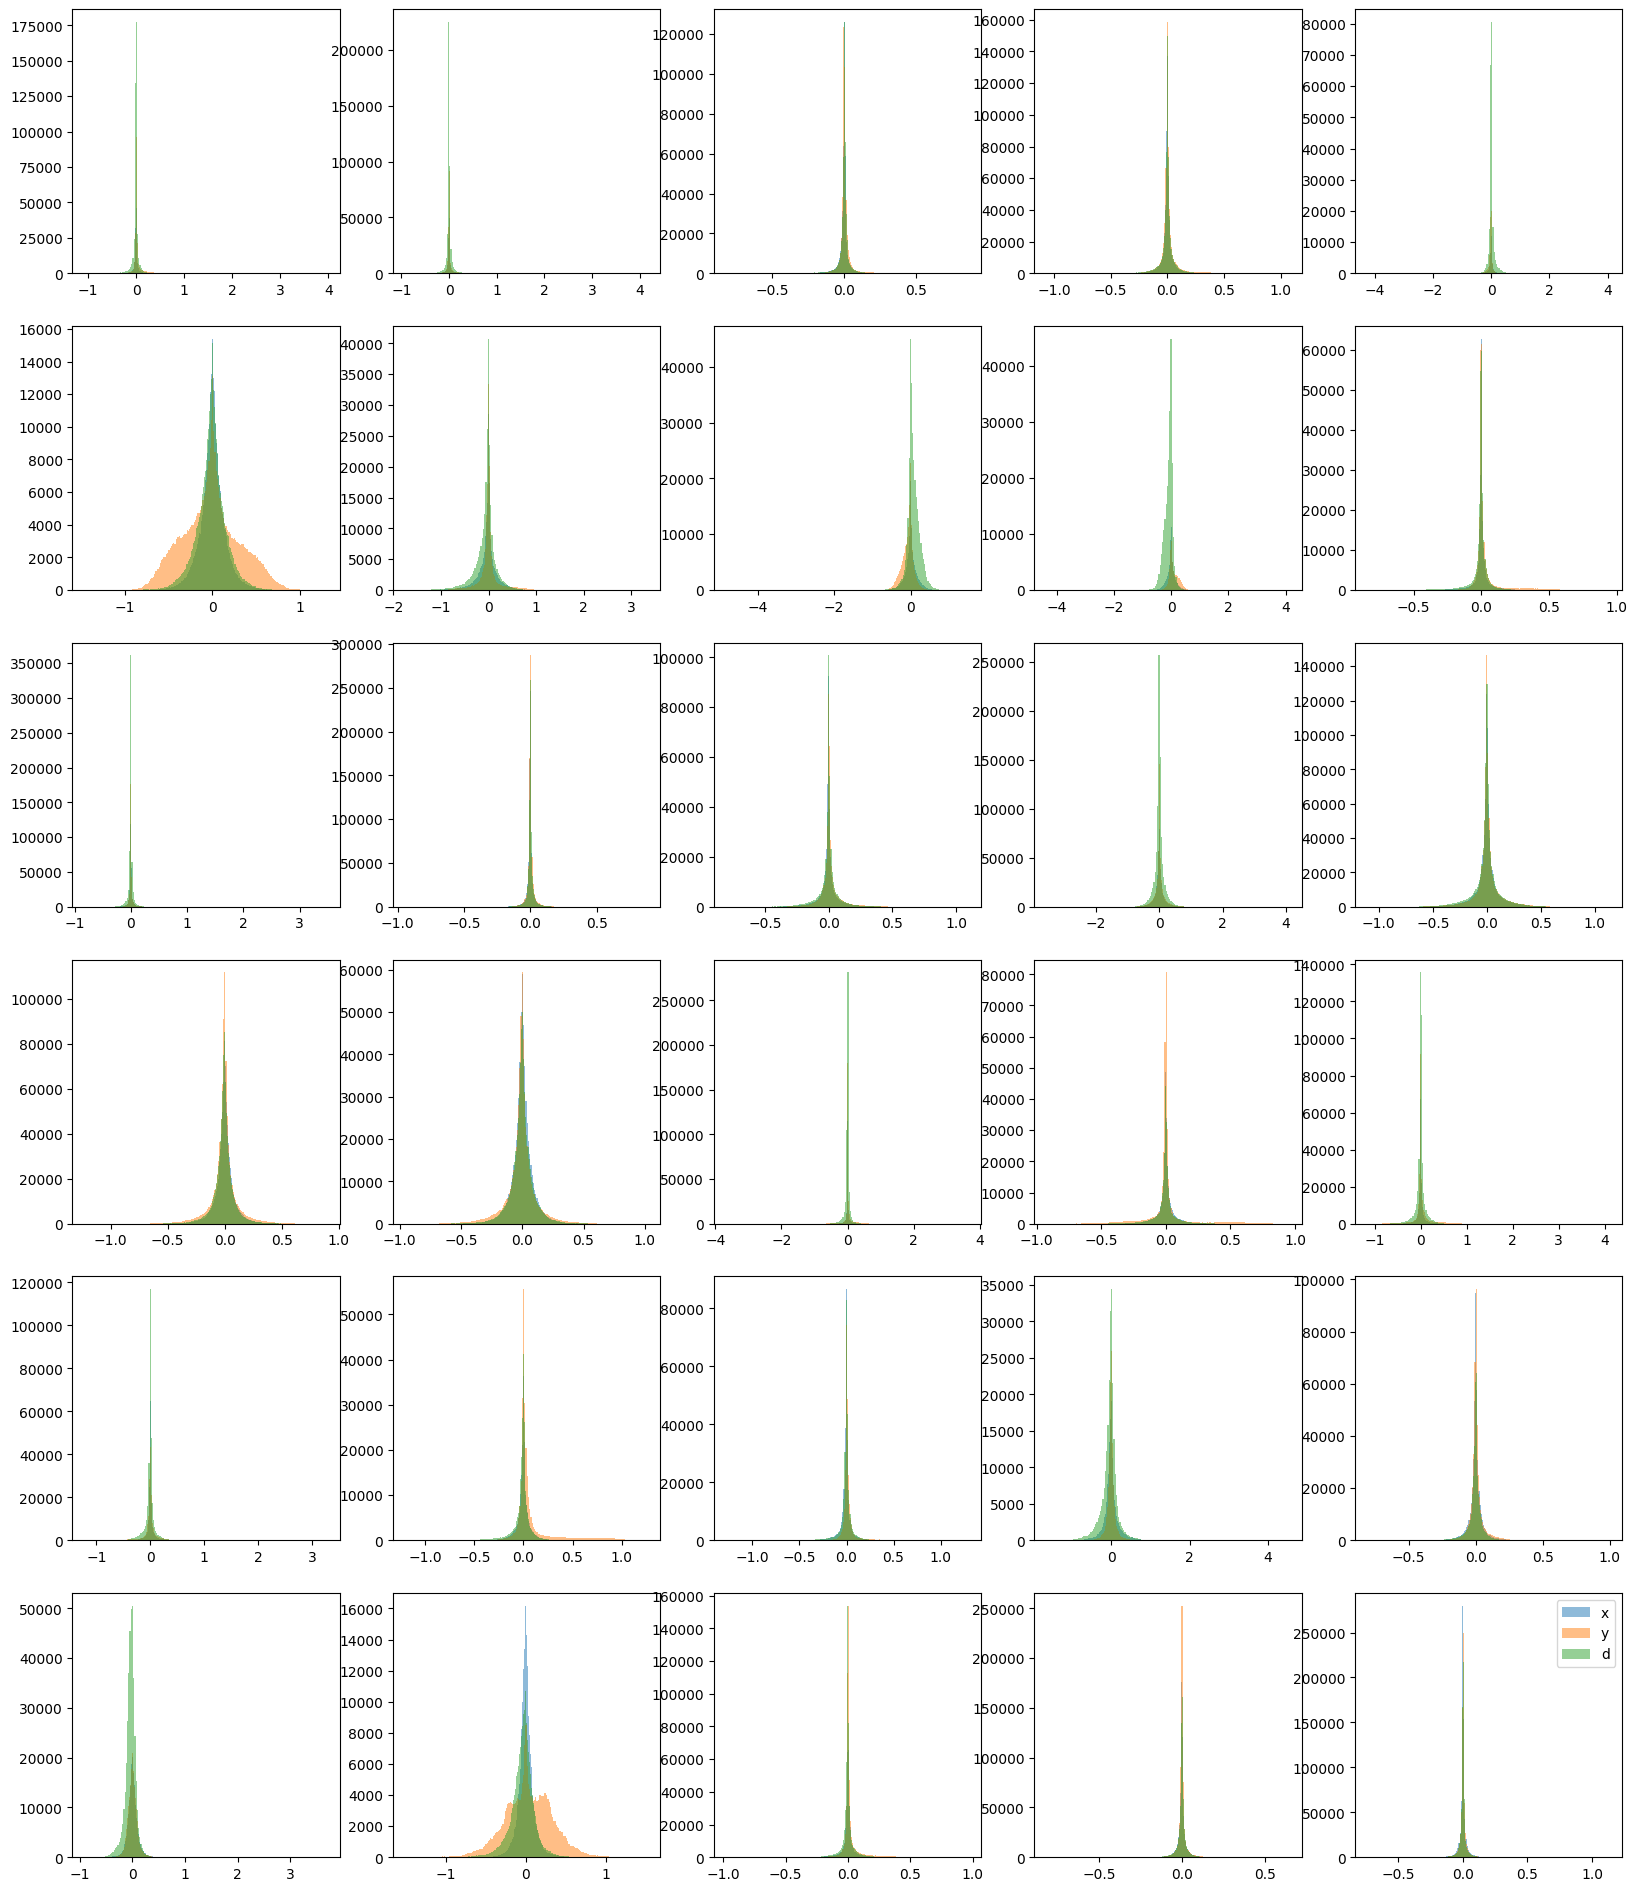

In [11]:
stride = 20
v = x[:, stride:] - x[:, :-stride]
for i in range(3):
    v_tmp = v.reshape(-1, 3)
    print(np.nanmean(v_tmp[:, i]), np.nanstd(v_tmp[:, i]))
plot_hist(v)

-3.5013858e-05 0.0105986195
0.0004625024 0.0141973905
-0.0003320189 0.015745915


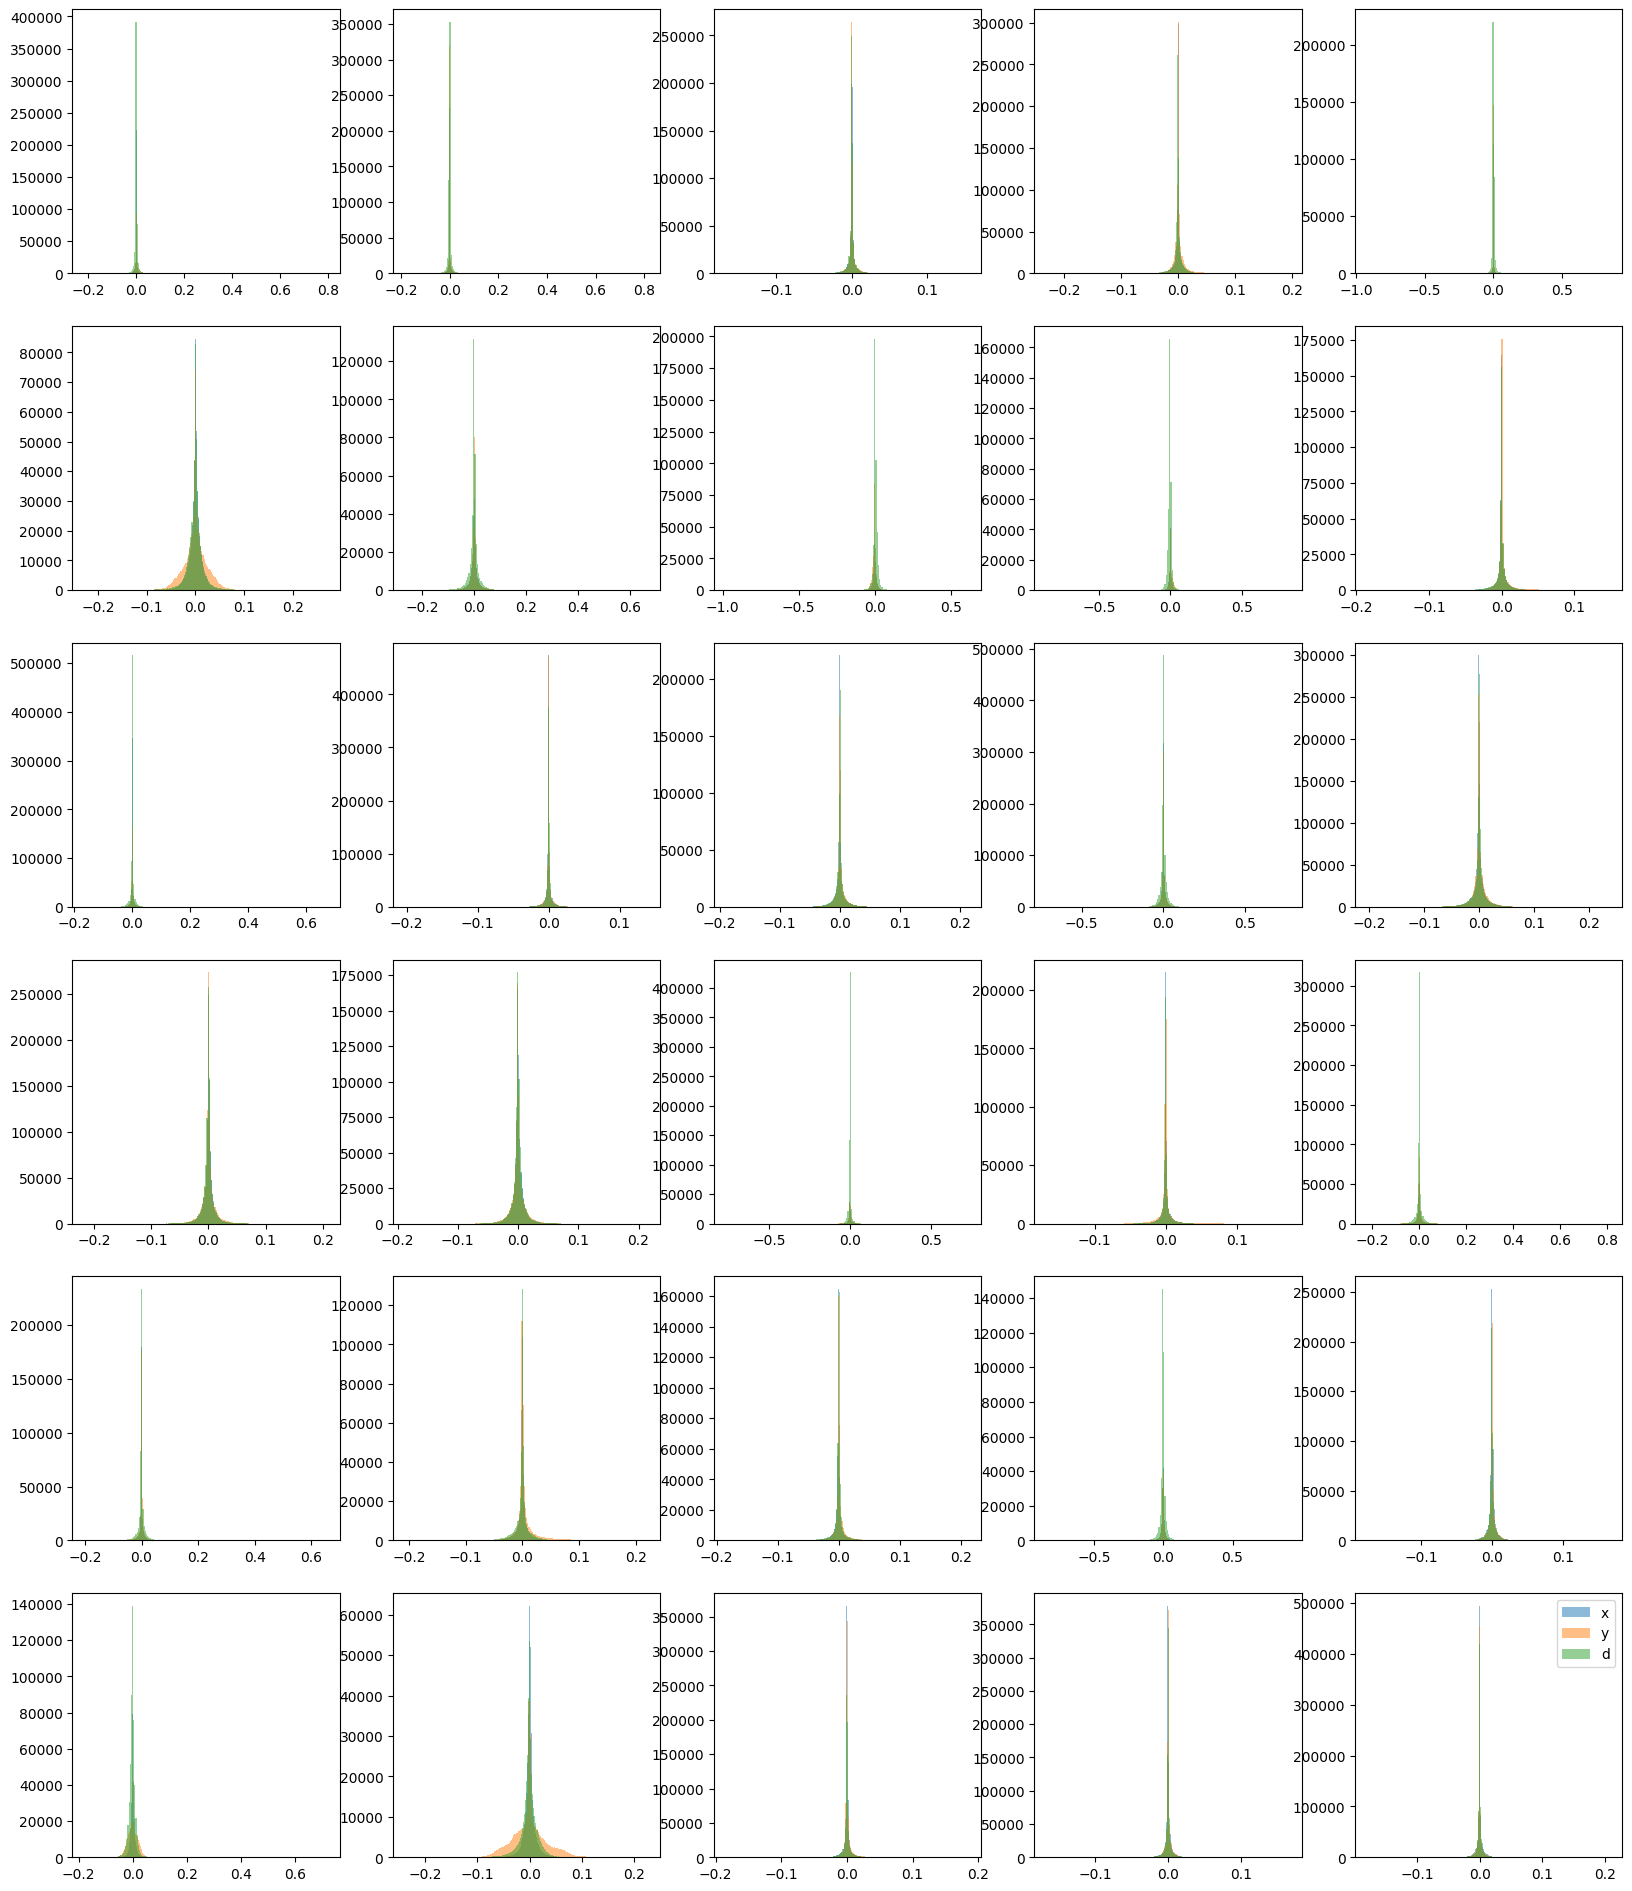

In [12]:
v = np.diff(x, axis=1)
for i in range(3):
    v_tmp = v.reshape(-1, 3)
    print(np.nanmean(v_tmp[:, i]), np.nanstd(v_tmp[:, i]))
plot_hist(v)

3.4680854e-06 0.007512691
-1.3654627e-05 0.0085598845
1.011179e-05 0.010751076


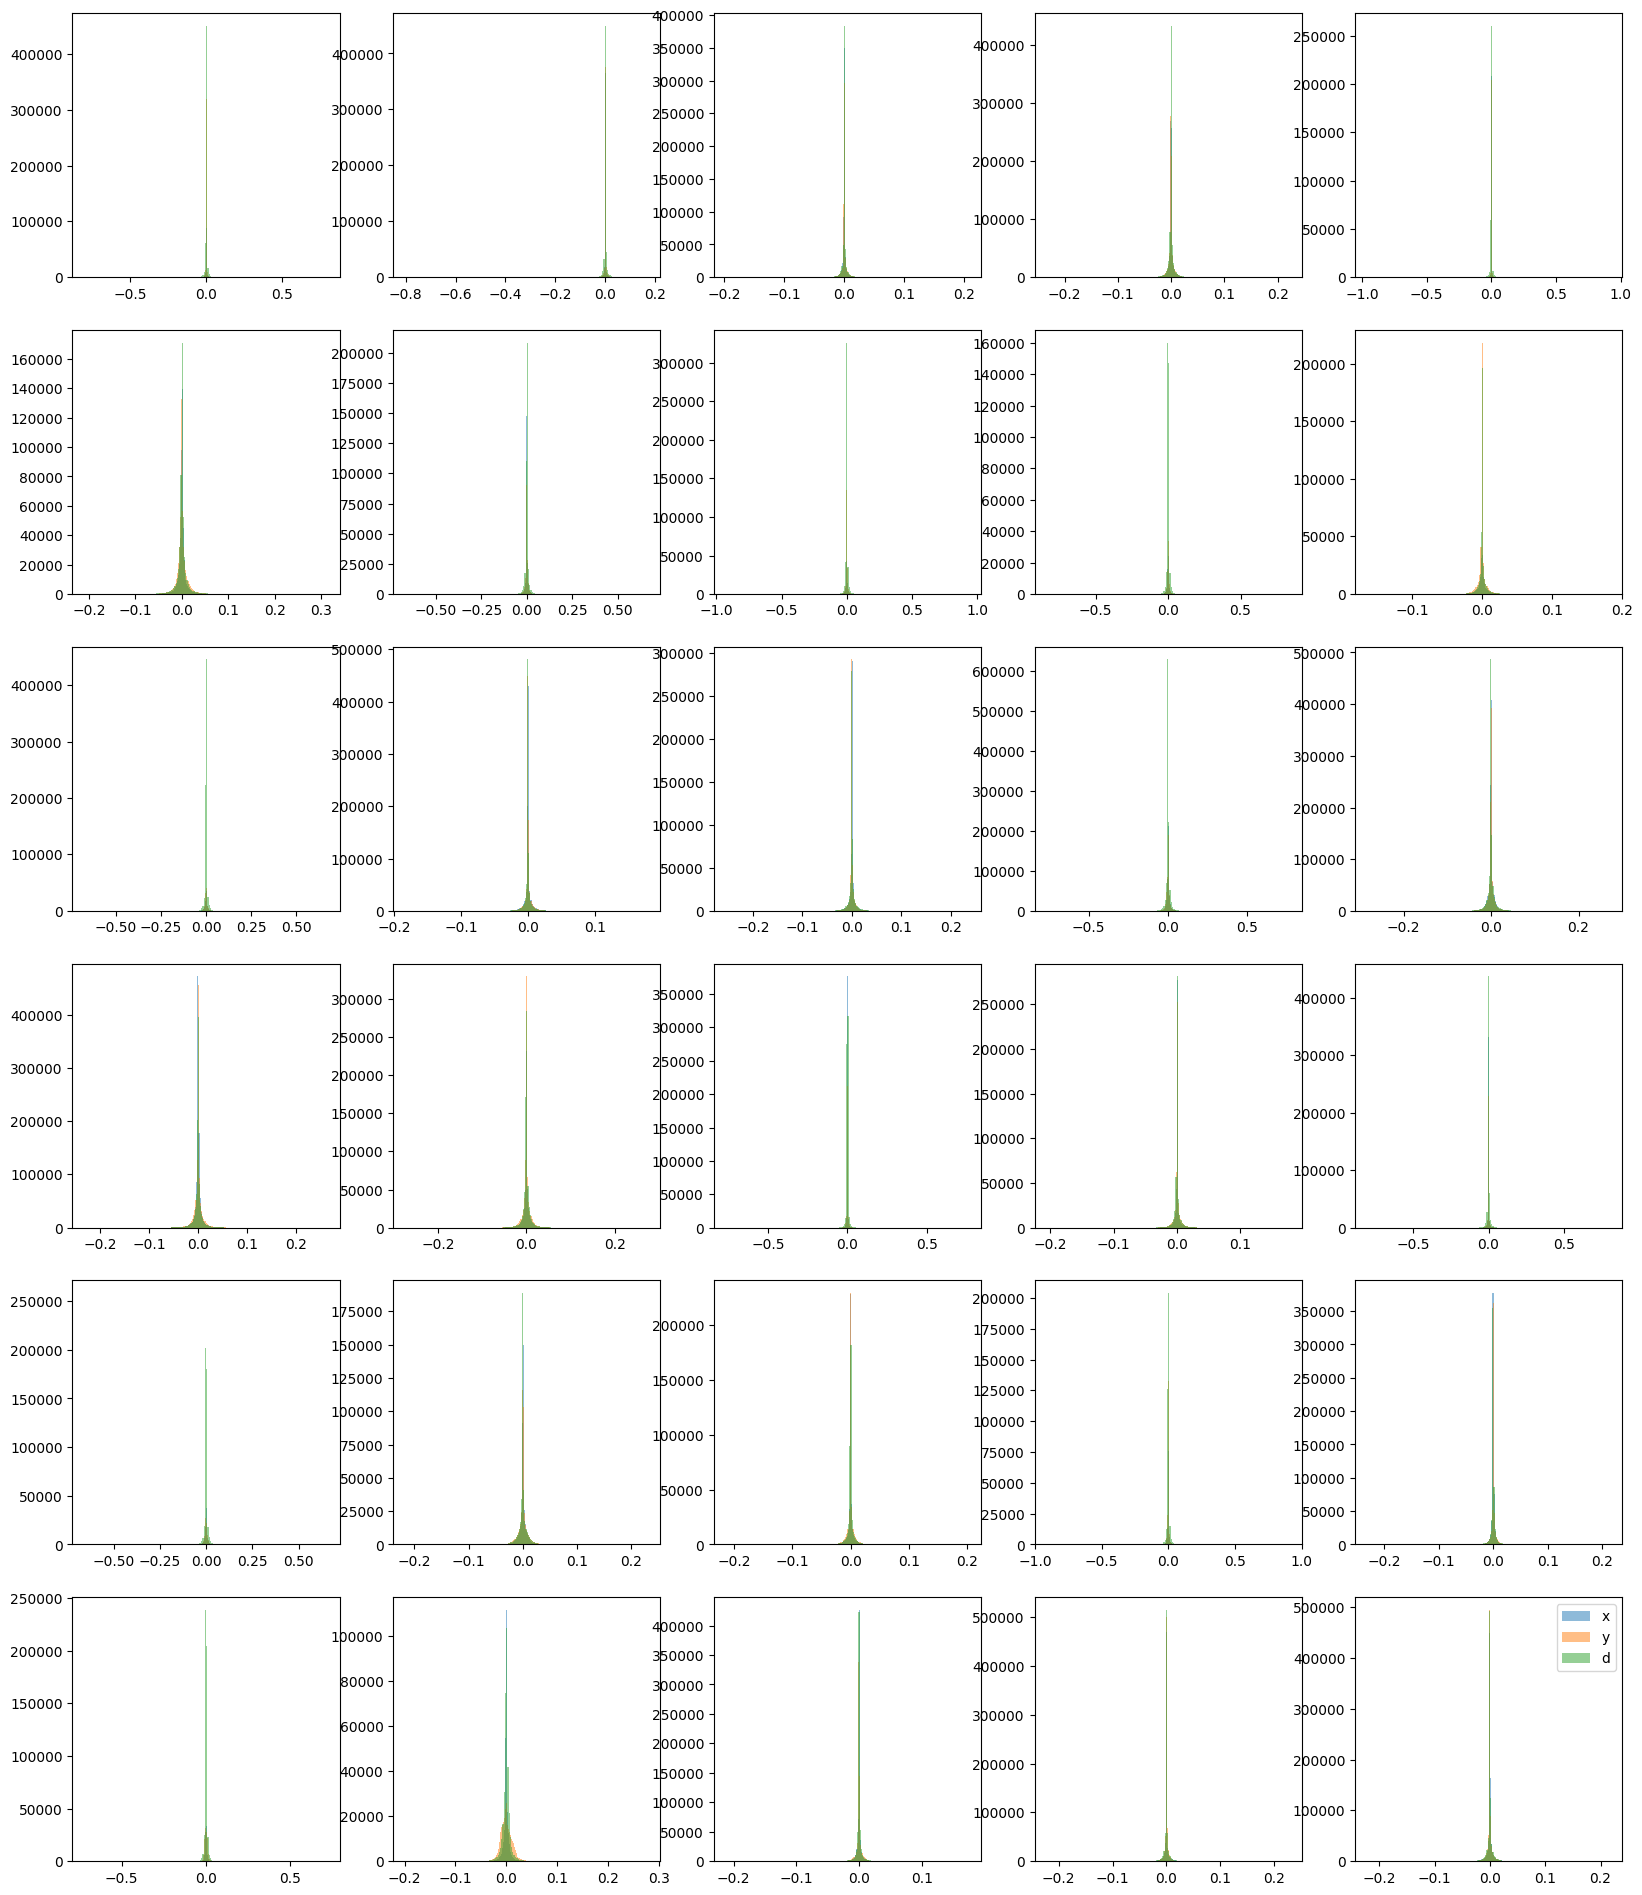

In [13]:
a = np.diff(v, axis=1)
for i in range(3):
    a_tmp = a.reshape(-1, 3)
    print(np.nanmean(a_tmp[:, i]), np.nanstd(a_tmp[:, i]))
plot_hist(a)

In [9]:
def rectangular2poloar(x):
    # x (width, heights, depth)
    x = x.reshape(-1, 3)
    r = np.linalg.norm(x, axis=1)
    theta = np.arccos(x[:, 1] / (r + 1e-10))
    phi = np.arccos(x[:, 0] / (np.linalg.norm(x[:, 0::2], axis=1) + 1e-10))
    phi[x[:, 2] == 0] = 0
    phi[x[:, 2] < 0] = phi[x[:, 2] < 0] * -1
    return r, theta, phi

3.3691983 0.5329605


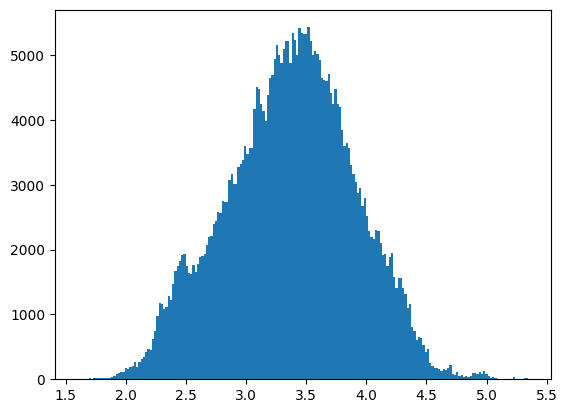

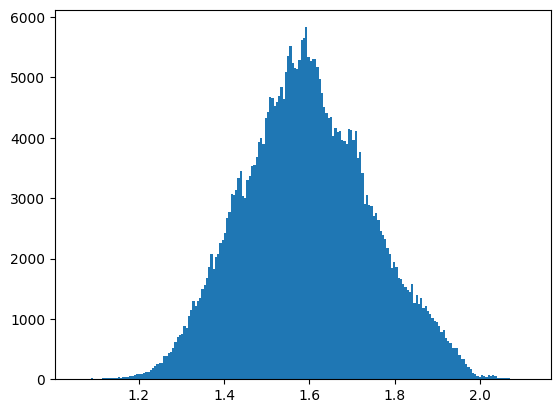

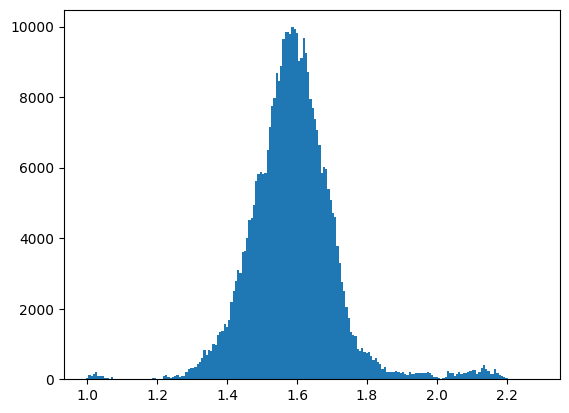

In [10]:
x1 = x.reshape(-1, 3)
x1 = x1[np.all(~np.isnan(x1), axis=1)]
r, theta, phi = rectangular2poloar(x1)
print(r.mean(), r.std())
plt.hist(r, bins=200)
plt.show()
plt.hist(theta, bins=200)
plt.show()
plt.hist(phi, bins=200)
plt.show()

0.029391365 0.027140498


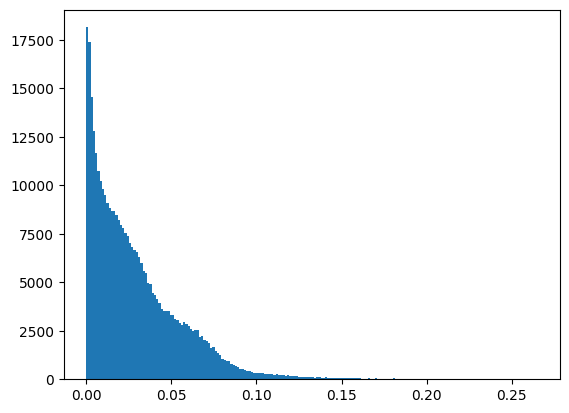

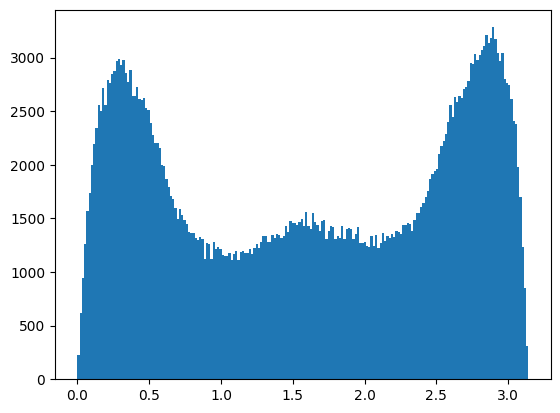

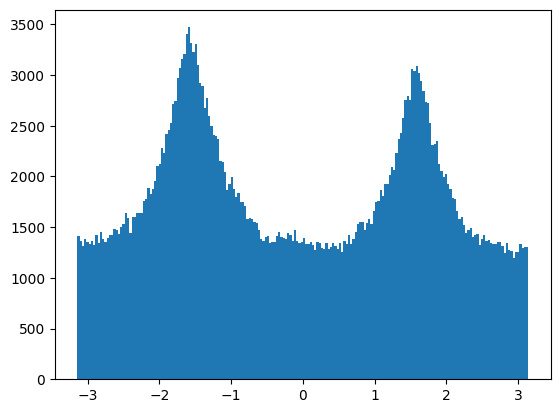

In [11]:
v = v.reshape(-1, 3)
v = v[np.all(~np.isnan(v), axis=1)]
r, theta, phi = rectangular2poloar(v)
print(r.mean(), r.std())
plt.hist(r, bins=200)
plt.show()
plt.hist(theta, bins=200)
plt.show()
plt.hist(phi, bins=200)
plt.show()

0.011535712 0.011919074


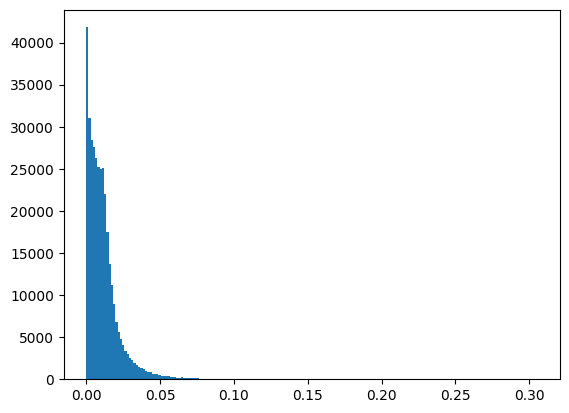

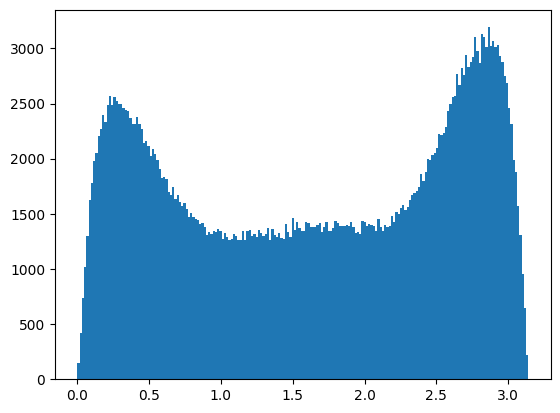

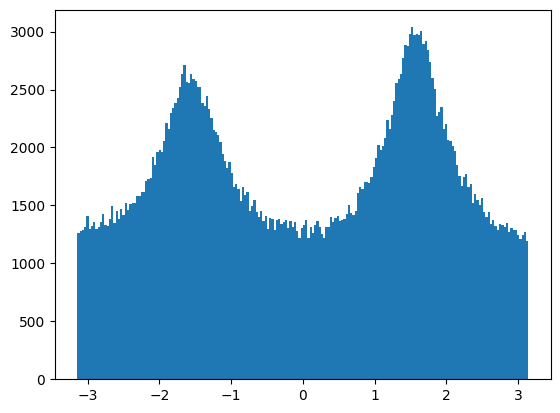

In [12]:
a = a.reshape(-1, 3)
a = a[np.all(~np.isnan(a), axis=1)]
r, theta, phi = rectangular2poloar(a)
print(r.mean(), r.std())
plt.hist(r, bins=200)
plt.show()
plt.hist(theta, bins=200)
plt.show()
plt.hist(phi, bins=200)
plt.show()